## 프로젝트

본 프로젝트는 실전 투자 전략의 효과를 정량적으로 검증함으로써, 암호화폐 시장에 대한 이해를 높이고 향후 자동매매 시스템 설계에 실무적·분석적 기초자료를 제공하는 것을 목적으로 한다.

- Upbit API를 활용하여 BTC/KRW의 30분봉 가격 데이터를 수집하고, 대표적인 기술적 분석 지표(MACD, RSI, EMA12/26)를 계산한다.

- 각 지표를 활용한 단일 매매 전략(MACD 교차, RSI 과매도/과매수, EMA 돌파)을 설계하고, 동일한 데이터 환경에서 전략별 누적 수익률을 백테스트하여 비교 분석한다.

- 전략별 매수·매도 타이밍 로직을 구현하고, 실제 거래소(업비트, 바이낸스 등)에서 사용하는 차트 스타일을 모방한 기술적 지표 시각화를 통해 성과를 직관적으로 파악한다.

- 향후 머신러닝 기반 전략 강화를 위한 기반 작업으로서, 전략별 수익률 패턴과 신호 민감도 등의 특성을 정리하여 자동화된 투자 시스템 개발의 출발점으로 삼는다.

### 0) 라이브러리 설치

```
pip install -r requirements.txt
```

In [1]:
# https://github.com/sharebook-kr/pyupbit
import pyupbit
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

In [2]:
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 폰트 설정
plt.rcParams['axes.unicode_minus'] = False # 음수 깨짐 방지

### 1) 데이터 수집

업비트 API를 활용하여 주요 암호화폐(BTC, ETH 등)의 일별 시세 데이터를 수집한다.

#### -절차

1. Upbit API(https://docs.upbit.com/)를  활용하여 원하는 코인의 OHLCV(시가, 고가, 저가, 종가, 거래량) 데이터를 일 단위로 요청한다. 데이터 요청 시 최대 200개의 캔들 데이터를 가져올 수 있으므로, 필요한 기간에 맞게 여러 번 나눠서 호출한다.

2. 수집한 데이터에서 필요한 컬럼(시가, 종가, 고가, 저가, 거래량 등)을 추출하여 DataFrame으로 저장한다.

3. 결측치와 이상치를 확인하여 처리하고, 이후 분석 및 머신러닝에 사용할 수 있도록 전처리한다.

4. 최종적으로 btc_daily_ohlcv.csv, eth_daily_ohlcv.csv 등 CSV 파일로 저장하여 분석에 활용한다.

In [3]:
def fetch_ohlcv_all(tickers, interval="day", count=200, save_path="../data/"):
    """
    여러 코인에 대해 OHLCV 데이터 수집 및 CSV 저장
    
    :param tickers: 리스트, 예) ["KRW-BTC", "KRW-ETH"]
    :param interval: str, 캔들 간격 (day, minute1, week 등)
    :param count: int, 한 번에 가져올 캔들 개수 (최대 200)
    :param save_path: str, 저장할 폴더 경로
    """
    for ticker in tickers:
        print(f"Fetching data for {ticker}...")
        df = pd.DataFrame()
        to = None

        while True:
            temp_df = pyupbit.get_ohlcv(ticker, interval=interval, count=count, to=to)
            if temp_df is None or temp_df.empty:
                break
            df = pd.concat([temp_df, df])
            to = temp_df.index[0]
            if len(temp_df) < count:
                break
            time.sleep(0.2)  # API 과부하 방지용 딜레이
        
        df = df[~df.index.duplicated(keep='first')]  # 중복 제거
        df.sort_index(inplace=True)
        
        filename = save_path + f"{ticker.replace('-', '_').lower()}_ohlcv.csv"
        df.to_csv(filename)
        print(f"Saved {filename}, rows: {len(df)}")

In [4]:
tickers = ["KRW-BTC", "KRW-ETH", "KRW-XRP"]
fetch_ohlcv_all(tickers)

Fetching data for KRW-BTC...
Saved ../data/krw_btc_ohlcv.csv, rows: 2930
Fetching data for KRW-ETH...
Saved ../data/krw_eth_ohlcv.csv, rows: 2927
Fetching data for KRW-XRP...
Saved ../data/krw_xrp_ohlcv.csv, rows: 2927


### 2) 탐색적 데이터 분석 (EDA)

#### -데이터 확인
##### --데이터 형태
- 암호화폐 일봉 가격 및 거래량 데이터

In [5]:
ticker = "KRW-BTC"
filename = f"../data/{ticker.replace('-', '_').lower()}_ohlcv.csv"
df = pd.read_csv(filename, index_col=0, parse_dates=True)

##### --주요 변수
- `open`: 시가
- `high`: 고가
- `low`: 저가
- `close`: 종가
- `volume`: 거래량 (코인 단위)
- `value`: 거래대금 (KRW 단위)

In [6]:
# 상위 5개 행 확인
df.head()

,open,high,low,close,volume,value
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08


In [7]:
# 기본 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2930 entries, 2017-09-25 09:00:00 to 2025-10-02 09:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2930 non-null   float64
 1   high    2930 non-null   float64
 2   low     2930 non-null   float64
 3   close   2930 non-null   float64
 4   volume  2930 non-null   float64
 5   value   2930 non-null   float64
dtypes: float64(6)
memory usage: 160.2 KB


In [8]:
# 기초 통계량 확인
df.describe()

,open,high,low,close,volume,value
count,2.930000e+03,2.930000e+03,2.930000e+03,2.930000e+03,2930.000000,2.930000e+03
mean,4.575099e+07,4.658912e+07,4.487246e+07,4.580631e+07,7132.770973,2.476706e+11
std,4.355206e+07,4.414525e+07,4.294789e+07,4.360251e+07,8113.113068,2.825929e+11
min,3.620000e+06,3.685000e+06,3.562000e+06,3.619000e+06,3.352825,2.166749e+07
25%,1.075050e+07,1.095625e+07,1.051025e+07,1.075125e+07,2764.636335,5.676190e+10
50%,3.218850e+07,3.291800e+07,3.162600e+07,3.233200e+07,4725.934981,1.556556e+11
75%,6.200850e+07,6.367400e+07,6.022400e+07,6.216675e+07,8319.090477,3.264475e+11
max,1.684240e+08,1.699000e+08,1.677090e+08,1.684240e+08,101681.962251,2.304644e+12


In [9]:
# 결측치 개수 확인
print(f'결측치 개수: {df.isnull().sum()}\n')

# 결측치 비율 확인
print(f'결측치 비율: {df.isnull().mean()*100}')

결측치 개수: open      0
high      0
low       0
close     0
volume    0
value     0
dtype: int64

결측치 비율: open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
value     0.0
dtype: float64


##### --데이터 활용

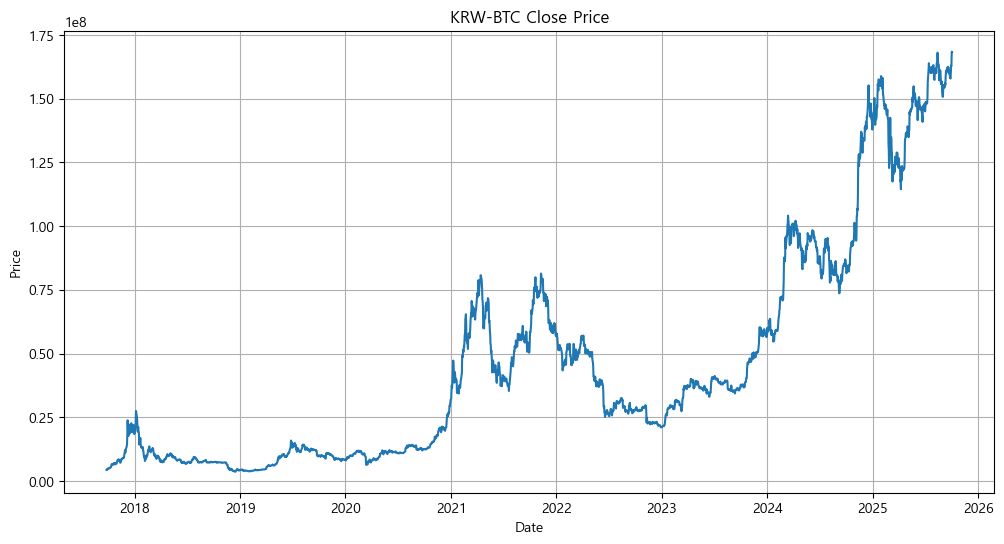

In [10]:
# 종가(close) 가격 시계열 그래프 그리기

plt.figure(figsize=(12,6))
plt.plot(df.index, df['close'])
plt.title(f'{ticker} Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

#### -데이터 전처리

##### --결측치 처리
- 데이터 누락 여부 확인 (isnull(), dropna(), fillna())
- 일부 시간대 데이터가 빠질 수 있으니 적절히 보완하거나 제거

In [11]:
# df_clean = df.dropna()

##### --이상치 처리
- 가격이나 거래량 급격한 변동 확인 (예: 가격이 0이거나 음수, 거래량 급감 등)
- 통계적 방법(사분위수, Z-score 등)으로 극단치 탐지 후 처리 또는 제거


In [12]:
# 가격이나 거래량이 0 이하인 이상치 탐색

print("이상치 (가격 또는 거래량이 0 이하) 개수:")
print((df[['open', 'high', 'low', 'close', 'volume', 'value']] <= 0).sum())

이상치 (가격 또는 거래량이 0 이하) 개수:
open      0
high      0
low       0
close     0
volume    0
value     0
dtype: int64


In [13]:
# 가격이 음수거나 0인 행 제거

condition = (df[['open', 'high', 'low', 'close']] > 0).all(axis=1) & (df['volume'] > 0)
df = df[condition]
df

,open,high,low,close,volume,value
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...
2025-09-28 09:00:00,157892000.0,160800000.0,157559000.0,160579000.0,1115.146549,1.766208e+11
2025-09-29 09:00:00,160579000.0,163200000.0,159300000.0,162976000.0,1561.776560,2.522337e+11
2025-09-30 09:00:00,162976000.0,163655000.0,161111000.0,162828000.0,1347.684652,2.191581e+11
2025-10-01 09:00:00,162828000.0,168429000.0,162789000.0,168424000.0,2391.533491,3.958172e+11


In [14]:
# 통계적 방법 (IQR)으로 극단치 탐지 - close 기준

Q1 = df['close'].quantile(0.25)
Q3 = df['close'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['close'] < lower_bound) | (df['close'] > upper_bound)]
print(f"\nClose 가격 IQR 이상치 개수: {len(outliers)}")


Close 가격 IQR 이상치 개수: 224


##### --자료형 변환
- 날짜 인덱스나 컬럼을 datetime 타입으로 변환
- 숫자형 컬럼(open, high, low, close, volume, value)이 정확히 float 또는 int 타입인지 확인 및 변환


In [15]:
# 인덱스가 datetime 형식인지 확인
print(f"인덱스 타입: {type(df.index)}")

# 인덱스가 datetime이 아니라면 변환
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)
    print("인덱스를 datetime 형식으로 변환 완료")

인덱스 타입: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [16]:
# 컬럼별 자료형 확인
print("\n컬럼별 자료형:")
print(df.dtypes)

# 숫자형 컬럼이 float 또는 int가 아니면 변환
num_cols = ['open', 'high', 'low', 'close', 'volume', 'value']
for col in num_cols:
    if not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print("인덱스를 float 또는 int 형식으로 변환 완료")


컬럼별 자료형:
open      float64
high      float64
low       float64
close     float64
volume    float64
value     float64
dtype: object


#### -파생 변수 생성
- 이동평균선 (EMA, SMA)
- 기술적 지표 (RSI, MACD, Bollinger Bands 등)
- 거래량 변화율, 수익률 등 전략에 필요한 변수 추가

In [17]:
# 30분봉 데이터 불러오기 (최대 200개 제한 있음)
df = pyupbit.get_ohlcv("KRW-BTC", interval="minute30", count=200)

# 컬럼명 맞추기 (mplfinance는 'Open', 'High' 등 대소문자 구분)
df.rename(columns={ 
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)

In [18]:
# EMA
df['EMA12'] = df['Close'].ewm(span=12).mean()
df['EMA26'] = df['Close'].ewm(span=26).mean()

# MACD
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal'] = df['MACD'].ewm(span=9).mean()

# RSI
delta = df['Close'].diff()
gain = delta.clip(lower=0).rolling(window=14).mean()
loss = -delta.clip(upper=0).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

### 3) 시각화

- 매매 전략 수립 및 백테스트
- 전략별 수익률 비교 및 시각화

##### -기초 통계

In [19]:
df.describe()

,Open,High,Low,Close,Volume,value,EMA12,EMA26,MACD,Signal,RSI
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,200.000000,2.000000e+02,2.000000e+02,2.000000e+02,200.000000,200.000000,186.000000
mean,1.622646e+08,1.624828e+08,1.621017e+08,1.623197e+08,36.386356,5.949924e+09,1.620275e+08,1.617005e+08,326964.832934,312497.647789,60.842585
std,3.117162e+06,3.172229e+06,3.078727e+06,3.131122e+06,38.749050,6.406541e+09,2.989488e+06,2.814335e+06,297773.986904,276704.732097,16.720300
min,1.576200e+08,1.577240e+08,1.575590e+08,1.576200e+08,1.309541,2.074877e+08,1.576885e+08,1.577003e+08,-285308.125581,-187669.954459,0.594422
25%,1.598132e+08,1.599970e+08,1.595805e+08,1.598732e+08,15.042652,2.372626e+09,1.597360e+08,1.593220e+08,64199.051308,49773.325389,54.698473
50%,1.624540e+08,1.627295e+08,1.622750e+08,1.624615e+08,25.063131,4.124623e+09,1.623424e+08,1.621544e+08,277548.568739,262157.833089,62.871816
75%,1.635595e+08,1.637622e+08,1.633845e+08,1.636222e+08,40.373190,6.615445e+09,1.634102e+08,1.631277e+08,589136.977934,562542.696424,71.234741
max,1.692560e+08,1.694950e+08,1.687860e+08,1.692560e+08,258.990544,4.271151e+10,1.684218e+08,1.677695e+08,846096.886732,768070.970267,92.058288


c:\Users\SSAFY\Desktop\04_05-pjt\pjt-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\04_05-pjt\pjt-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48393 (\N{HANGUL SYLLABLE BONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\04_05-pjt\pjt-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\04_05-pjt\pjt-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\04_05-pjt\pjt-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL S

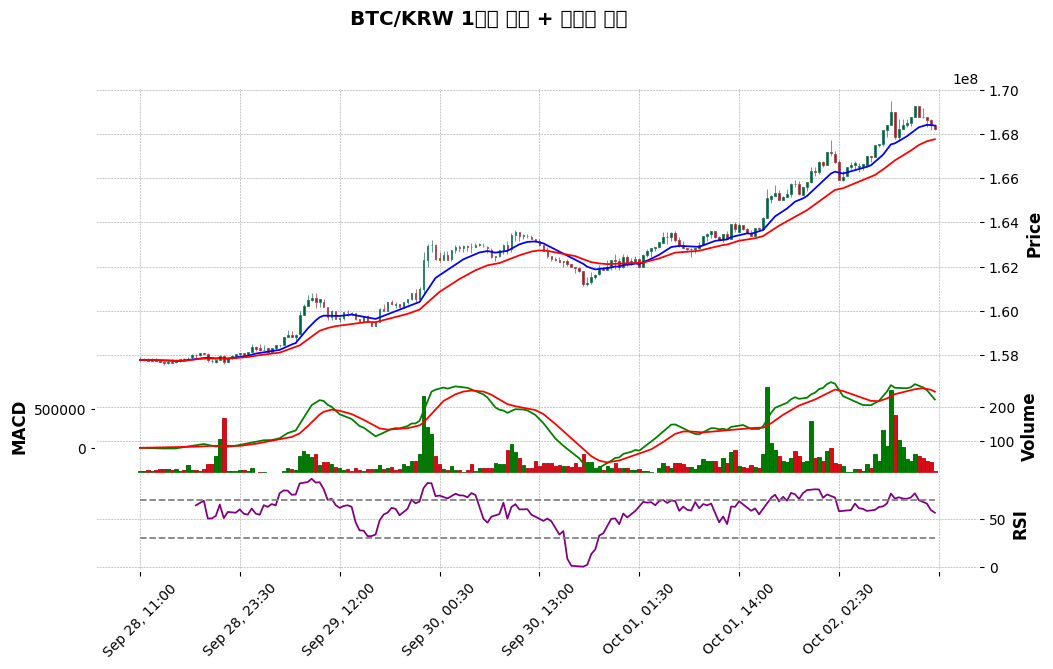

In [20]:
# 가격 + EMA 차트
apds = [
    mpf.make_addplot(df['EMA12'], color='blue'),
    mpf.make_addplot(df['EMA26'], color='red')
]

# MACD subplot
macd_apds = [
    mpf.make_addplot(df['MACD'], panel=1, color='g', ylabel='MACD'),
    mpf.make_addplot(df['Signal'], panel=1, color='r')
]

# RSI subplot + 기준선
rsi_apds = [
    mpf.make_addplot(df['RSI'], panel=2, color='purple', ylabel='RSI'),
    mpf.make_addplot([30]*len(df), panel=2, color='gray', linestyle='--'),
    mpf.make_addplot([70]*len(df), panel=2, color='gray', linestyle='--')
]

# 전체 차트 그리기
mpf.plot(
    df,
    type='candle',           # 캔들차트
    style='charles',
    addplot=apds + macd_apds + rsi_apds,
    volume=True,
    panel_ratios=(6,2,2),    # 가격:MACD:RSI 비율
    figratio=(16,9),
    figscale=1.2,
    title='BTC/KRW 1분봉 차트 + 기술적 지표',
)

MACD 전략 누적 수익률: 4.7%
RSI 전략 누적 수익률: 1.91%
EMA 전략 누적 수익률: 4.5%


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_3896\1927027421.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not position and buy_signal[i]:
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_3896\1927027421.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif position and sell_signal[i]:


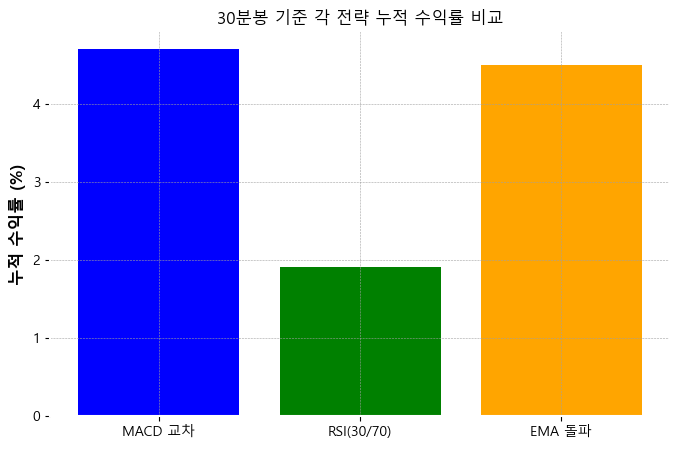

In [21]:
# 공통 백테스트 함수
def simulate_trading(df, buy_signal, sell_signal):
    position = False
    entry_price = 0
    returns = []

    for i in range(1, len(df)):
        if not position and buy_signal[i]:
            entry_price = df['Close'].iloc[i]
            position = True
        elif position and sell_signal[i]:
            exit_price = df['Close'].iloc[i]
            ret = (exit_price - entry_price) / entry_price
            returns.append(ret)
            position = False

    return np.cumprod([1 + r for r in returns])[-1] if returns else 1.0


# 전략 1: MACD 교차
macd_buy = (df['MACD'] > df['Signal']) & (df['MACD'].shift(1) <= df['Signal'].shift(1))
macd_sell = (df['MACD'] < df['Signal']) & (df['MACD'].shift(1) >= df['Signal'].shift(1))
macd_return = simulate_trading(df, macd_buy, macd_sell)

# 전략 2: RSI 기준
rsi_buy = df['RSI'] < 30
rsi_sell = df['RSI'] > 70
rsi_return = simulate_trading(df, rsi_buy, rsi_sell)

# 전략 3: EMA 돌파
ema_buy = (df['Close'] > df['EMA12']) & (df['Close'].shift(1) <= df['EMA12'].shift(1))
ema_sell = (df['Close'] < df['EMA12']) & (df['Close'].shift(1) >= df['EMA12'].shift(1))
ema_return = simulate_trading(df, ema_buy, ema_sell)

# 결과 출력
print(f"MACD 전략 누적 수익률: {round((macd_return - 1) * 100, 2)}%")
print(f"RSI 전략 누적 수익률: {round((rsi_return - 1) * 100, 2)}%")
print(f"EMA 전략 누적 수익률: {round((ema_return - 1) * 100, 2)}%")

# 시각화
strategies = ['MACD 교차', 'RSI(30/70)', 'EMA 돌파']
returns = [macd_return, rsi_return, ema_return]

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(8, 5))
plt.bar(strategies, [(r - 1) * 100 for r in returns], color=['blue', 'green', 'orange'])
plt.ylabel('누적 수익률 (%)')
plt.title('30분봉 기준 각 전략 누적 수익률 비교')
plt.grid(True, axis='y')
plt.show()

In [22]:
# 골든크로스: EMA12가 EMA26을 아래에서 위로 돌파 
# 데드크로스: EMA12가 EMA26을 위에서 아래로 하향 돌파

df['EMA_diff'] = df['EMA12'] - df['EMA26']
df['EMA_cross'] = df['EMA_diff'].apply(lambda x: 1 if x > 0 else -1)

df['cross_signal'] = df['EMA_cross'].diff()

golden_crosses = df[df['cross_signal'] == 2]
dead_crosses = df[df['cross_signal'] == -2]

In [23]:
print("골든크로스 발생 시점:")
golden_crosses.tail()

골든크로스 발생 시점:


,Open,High,Low,Close,Volume,value,EMA12,EMA26,MACD,Signal,RSI,EMA_diff,EMA_cross,cross_signal
2025-09-28 11:30:00,157796000.0,157879000.0,157700000.0,157788000.0,10.697064,1.687834e+09,1.577784e+08,1.577779e+08,471.153846,261.752137,NaN,471.153846,1,2.0
2025-09-28 16:30:00,157800000.0,157839000.0,157751000.0,157778000.0,14.572507,2.299600e+09,1.577308e+08,1.577278e+08,3091.785043,-3541.046911,NaN,3091.785043,1,2.0
2025-10-01 02:00:00,162000000.0,162549000.0,161958000.0,162544000.0,10.901613,1.769961e+09,1.621815e+08,1.621813e+08,149.746292,-68183.469923,68.009012,149.746292,1,2.0


In [24]:
print("\n데드크로스 발생 시점:")
dead_crosses.tail()


데드크로스 발생 시점:


,Open,High,Low,Close,Volume,value,EMA12,EMA26,MACD,Signal,RSI,EMA_diff,EMA_cross,cross_signal
2025-09-28 12:00:00,157789000.0,157879000.0,157736000.0,157740000.0,12.398611,1.956291e+09,1.577634e+08,1.577643e+08,-888.133610,-209.512514,NaN,-888.133610,-1,-2.0
2025-09-30 16:30:00,162239000.0,162321000.0,162040000.0,162100000.0,24.077062,3.904729e+09,1.625411e+08,1.625581e+08,-17010.318114,166846.805187,8.760025,-17010.318114,-1,-2.0


##### -분포

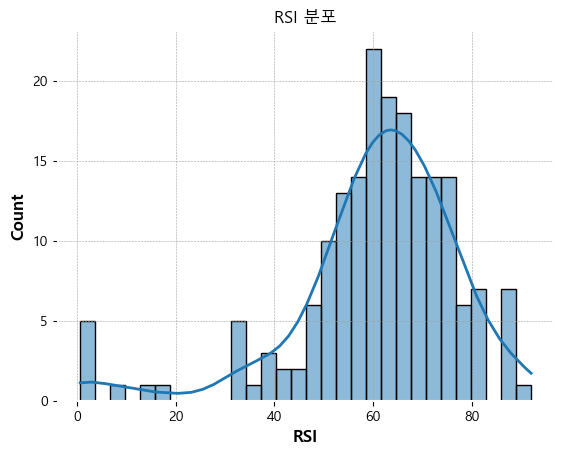

In [25]:
# RSI 분포
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.histplot(df['RSI'].dropna(), bins=30, kde=True)
plt.title("RSI 분포")
plt.show()

c:\Users\SSAFY\Desktop\04_05-pjt\pjt-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


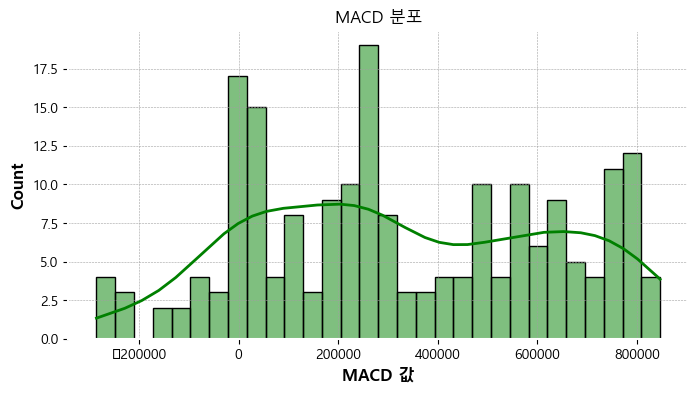

In [26]:
# MACD 분포
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(8,4))
sns.histplot(df['MACD'].dropna(), bins=30, kde=True, color='green')
plt.title("MACD 분포")
plt.xlabel("MACD 값")
plt.show()

c:\Users\SSAFY\Desktop\04_05-pjt\pjt-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


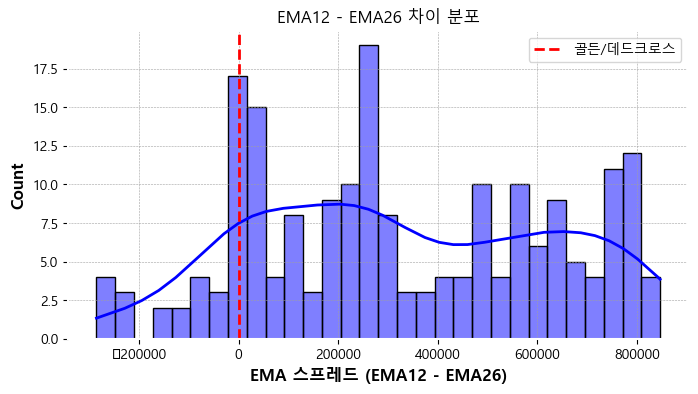

In [27]:
# EMA 차이의 분포

df['EMA_diff'] = df['EMA12'] - df['EMA26']

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(8,4))
sns.histplot(df['EMA_diff'].dropna(), bins=30, kde=True, color='blue')
plt.title("EMA12 - EMA26 차이 분포")
plt.xlabel("EMA 스프레드 (EMA12 - EMA26)")
plt.axvline(0, color='red', linestyle='--', label='골든/데드크로스')
plt.legend()
plt.show()

c:\Users\SSAFY\Desktop\04_05-pjt\pjt-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


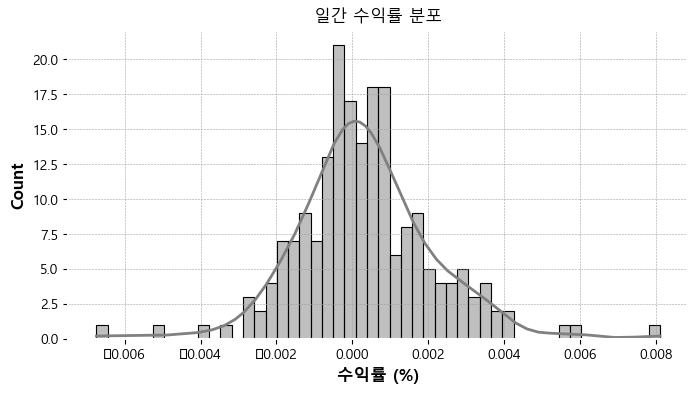

In [28]:
# 일간 수익률 분포
df['return'] = df['Close'].pct_change()

plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 폰트 설정
plt.figure(figsize=(8,4))
sns.histplot(df['return'].dropna(), bins=50, kde=True, color='gray')
plt.title("일간 수익률 분포")
plt.xlabel("수익률 (%)")
plt.show()

##### -빈도

In [29]:
def rsi_level(rsi):
    if rsi >= 70:
        return '과매수'
    elif rsi <= 30:
        return '과매도'
    else:
        return '정상'

df['RSI_level'] = df['RSI'].apply(rsi_level)
df['RSI_level'].value_counts()

RSI_level
정상     141
과매수     51
과매도      8
Name: count, dtype: int64

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_3896\2502577771.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RSI_level', data=df, order=['과매도', '정상', '과매수'], palette='coolwarm')


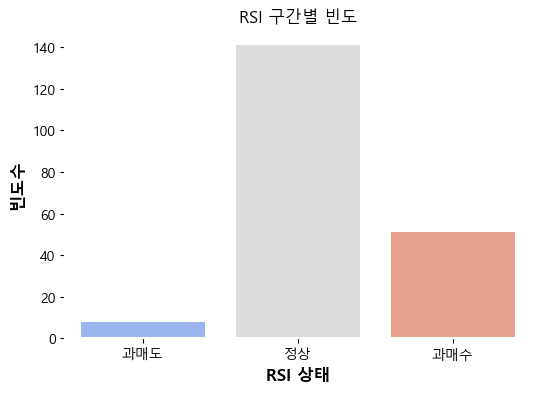

In [30]:
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 폰트 설정
plt.figure(figsize=(6,4))
sns.countplot(x='RSI_level', data=df, order=['과매도', '정상', '과매수'], palette='coolwarm')
plt.title("RSI 구간별 빈도")
plt.xlabel("RSI 상태")
plt.ylabel("빈도수")
plt.grid(axis='y')
plt.show()

In [31]:
# MACD가 양수면 '상승', 음수면 '하락'으로 라벨링
df['MACD_signal'] = df['MACD'].apply(lambda x: '상승' if x > 0 else '하락')

# 각 신호가 얼마나 자주 나타나는지 확인
macd_counts = df['MACD_signal'].value_counts()
print(macd_counts)

MACD_signal
상승    171
하락     29
Name: count, dtype: int64


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_3896\3036662042.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='MACD_signal', data=df, palette='Set2')


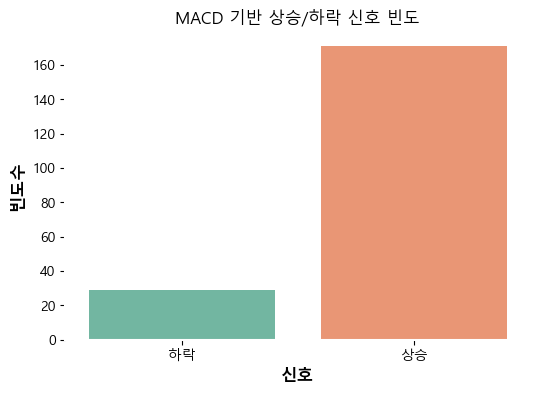

In [32]:
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 폰트 설정
plt.figure(figsize=(6,4))
sns.countplot(x='MACD_signal', data=df, palette='Set2')
plt.title("MACD 기반 상승/하락 신호 빈도")
plt.xlabel("신호")
plt.ylabel("빈도수")
plt.grid(axis='y')
plt.show()

##### -관계

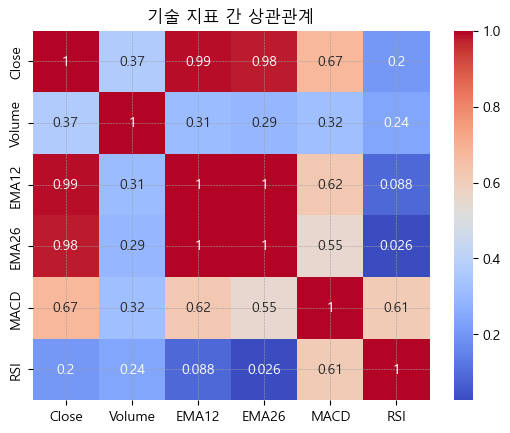

In [33]:
df_corr = df[['Close', 'Volume', 'EMA12', 'EMA26', 'MACD', 'RSI']].corr()
sns.heatmap(df_corr, annot=True, cmap='coolwarm')
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 폰트 설정
plt.title("기술 지표 간 상관관계")
plt.show()

거래량과 가격 변화폭의 상관계수: 0.7453


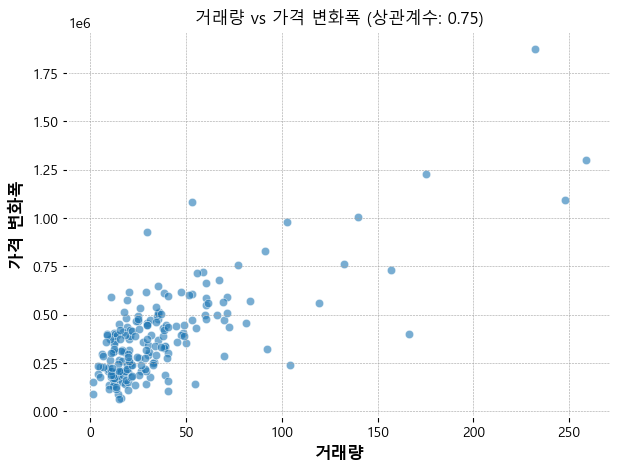

In [34]:
# 가격 변화폭: high - low
df['price_range'] = df['High'] - df['Low']

# 상관계수 계산
corr = df[['Volume', 'price_range']].corr().iloc[0,1]
print(f"거래량과 가격 변화폭의 상관계수: {corr:.4f}")

# 시각화
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 폰트 설정
plt.figure(figsize=(7,5))
sns.scatterplot(x='Volume', y='price_range', data=df, alpha=0.6)
plt.title(f"거래량 vs 가격 변화폭 (상관계수: {corr:.2f})")
plt.xlabel("거래량")
plt.ylabel("가격 변화폭")
plt.show()

### 4) 모델

기술적 지표 계산
- 30 이하 = 과매도
- 70 이상 = 과매수

EMA(지수 이동 평균)
- EMA12 > EMA26: 상승 추세 신호
- 종가 > EMA200: 장기적으로 우상향 흐름

MACD (이동평균 수렴 확산 지표)
- MACD > Signal: 매수 관점
- MACD < Signal: 매도 관점

In [47]:
import requests
import pandas as pd

import ta


def get_ohlcv(ticker="KRW-BTC", interval="5m", count=200):
    url = f"https://api.upbit.com/v1/candles/minutes/{interval}"
    querystring = {
        "market": ticker,
        "count": count
    }
    response = requests.get(url, params=querystring)
    data = response.json()
    df = pd.DataFrame(data)
    # 시간 역순이라 정렬
    df = df.iloc[::-1].reset_index(drop=True)
    return df

# 예시: 5분봉 200개 데이터
df_5m = get_ohlcv(interval="5", count=1000000)
df_10m = get_ohlcv(interval="10", count=1000000)
df_30m = get_ohlcv(interval="30", count=1000000)

print(df_5m.head())
print("##########################################################################")
# RSI 계산 (window=14)
df = df_5m.copy()  # 5분봉 데이터로 작업

# RSI 계산 (window=14)
df['rsi'] = ta.momentum.RSIIndicator(close=df['trade_price'], window=14).rsi()

# EMA 계산
df['ema12'] = ta.trend.EMAIndicator(close=df['trade_price'], window=12).ema_indicator()
df['ema26'] = ta.trend.EMAIndicator(close=df['trade_price'], window=26).ema_indicator()
df['ema200'] = ta.trend.EMAIndicator(close=df['trade_price'], window=200).ema_indicator()

# MACD 계산
macd = ta.trend.MACD(close=df['trade_price'], window_slow=26, window_fast=12, window_sign=9)
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()
df['macd_diff'] = macd.macd_diff()

# EMA12 / EMA26 교차 신호 (1: 골든크로스, -1: 데드크로스)
df['ema12_above_ema26'] = df['ema12'] > df['ema26']
df['ema_cross'] = df['ema12_above_ema26'].astype(int).diff()

# MACD / Signal 교차 신호
df['macd_above_signal'] = df['macd'] > df['macd_signal']
df['macd_cross'] = df['macd_above_signal'].astype(int).diff()

# EMA200 위/아래 위치 확인 (True: 위, False: 아래)
df['price_above_ema200'] = df['trade_price'] > df['ema200']

# 결과 출력
print(df.tail(30))

    market candle_date_time_utc candle_date_time_kst  opening_price  \
0  KRW-BTC  2025-10-01T13:15:00  2025-10-01T22:15:00    165370000.0   
1  KRW-BTC  2025-10-01T13:20:00  2025-10-01T22:20:00    165406000.0   
2  KRW-BTC  2025-10-01T13:25:00  2025-10-01T22:25:00    165546000.0   
3  KRW-BTC  2025-10-01T13:30:00  2025-10-01T22:30:00    165616000.0   
4  KRW-BTC  2025-10-01T13:35:00  2025-10-01T22:35:00    165580000.0   

    high_price    low_price  trade_price      timestamp  \
0  165406000.0  165370000.0  165406000.0  1759324798379   
1  165543000.0  165400000.0  165543000.0  1759325098526   
2  165626000.0  165546000.0  165616000.0  1759325399237   
3  165619000.0  165551000.0  165595000.0  1759325699529   
4  165687000.0  165551000.0  165630000.0  1759325997311   

   candle_acc_trade_price  candle_acc_trade_volume  unit  
0            6.546416e+08                 3.958220     5  
1            9.070672e+08                 5.481533     5  
2            9.369555e+08                

##### -매매 신호 정의 (EMA + MACD + RSI)

In [48]:
# 매수 조건: EMA 골든크로스 + MACD 골든크로스 + RSI > 30
df['buy_signal'] = (
    (df['ema_cross'] == 1) 
    
)

# 매도 조건: EMA 데드크로스
df['sell_signal'] = df['ema_cross'] == -1

##### -백테스트 로직 (매수 → 매도 → 수익률 저장)

In [49]:
def backtest(df):
    position = False
    entry_price = 0
    returns = []

    for i in range(len(df)):
        if df['buy_signal'].iloc[i] and not position:
            entry_price = df['trade_price'].iloc[i]
            position = True
        elif df['sell_signal'].iloc[i] and position:
            exit_price = df['trade_price'].iloc[i]
            ret = (exit_price - entry_price) / entry_price
            returns.append(ret)
            position = False
    
    return pd.Series(returns)

# 백테스트 실행
returns = backtest(df)
print("백테스트 결과 요약:")
print(returns.describe())
print(f"총 거래 횟수: {len(returns)}")
print(f"총 누적 수익률: {((1 + returns).prod() - 1) * 100:.2f}%")

백테스트 결과 요약:
count    2.000000
mean     0.005270
std      0.008489
min     -0.000733
25%      0.002268
50%      0.005270
75%      0.008271
max      0.011272
dtype: float64
총 거래 횟수: 2
총 누적 수익률: 1.05%


##### -시각화 (matplotlib)

In [38]:
print("Buy signals:", df['buy_signal'].sum())
print("Sell signals:", df['sell_signal'].sum())

Buy signals: 2
Sell signals: 2


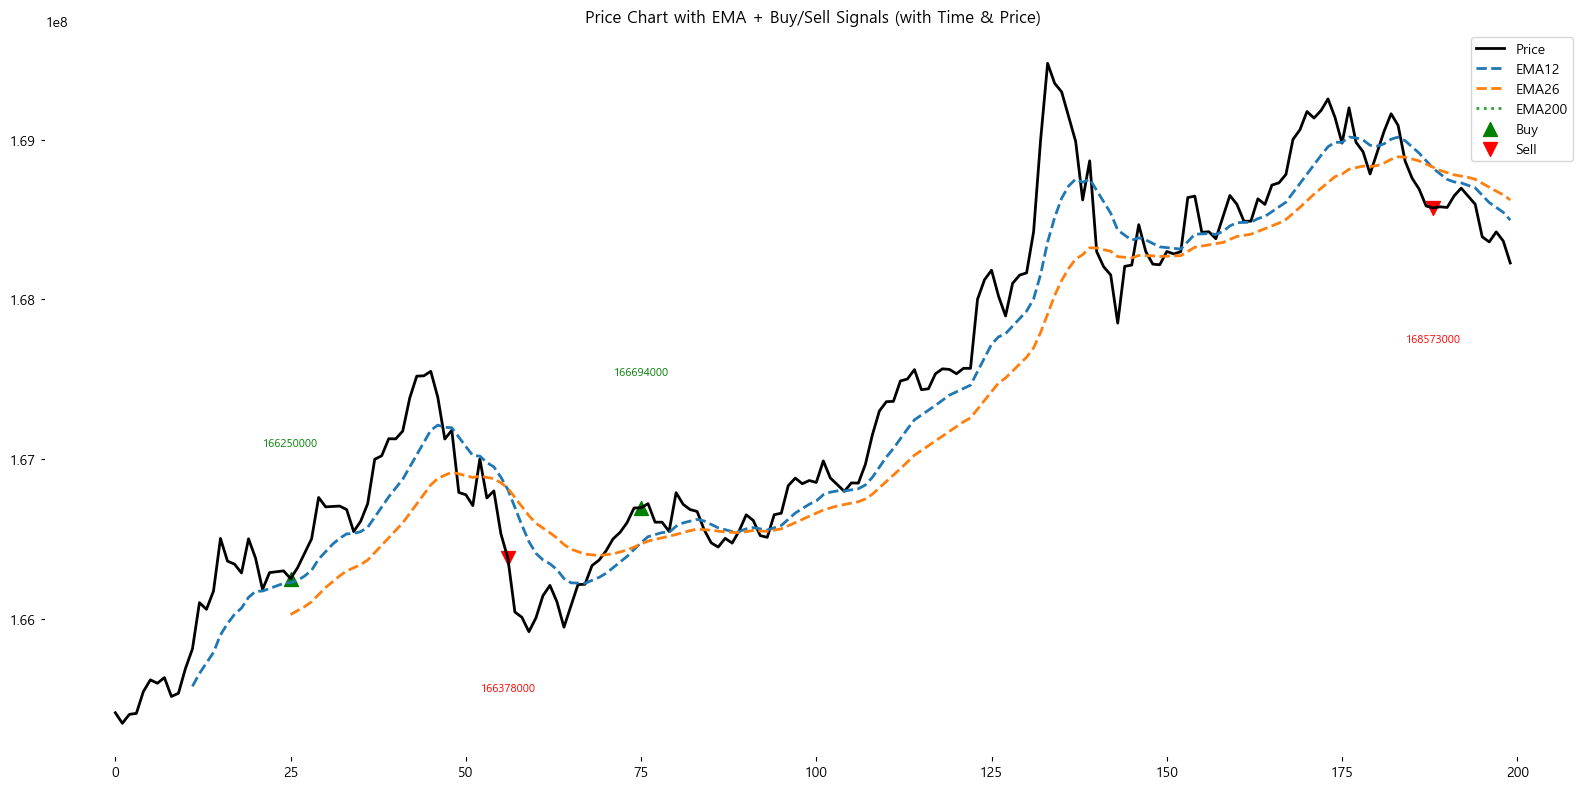

In [39]:
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['trade_price'], label='Price', color='black')
plt.plot(df.index, df['ema12'], label='EMA12', linestyle='--')
plt.plot(df.index, df['ema26'], label='EMA26', linestyle='--')
plt.plot(df.index, df['ema200'], label='EMA200', linestyle=':')

# Buy / Sell 신호 표시 (점 + 텍스트)
buy_points = df[df['buy_signal']]
sell_points = df[df['sell_signal']]

# 점 찍기
plt.scatter(buy_points.index, buy_points['trade_price'], marker='^', color='green', label='Buy', s=100)
plt.scatter(sell_points.index, sell_points['trade_price'], marker='v', color='red', label='Sell', s=100)

# 텍스트 추가
for idx, row in buy_points.iterrows():
    plt.text(idx, row['trade_price'] * 1.005, f"{row['trade_price']:.0f}", color='green', fontsize=8, ha='center')

for idx, row in sell_points.iterrows():
    plt.text(idx, row['trade_price'] * 0.995, f"{row['trade_price']:.0f}", color='red', fontsize=8, ha='center')

plt.title("Price Chart with EMA + Buy/Sell Signals (with Time & Price)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

##### -실시간 데이터 수집 & 신호 감지

In [40]:
import time

def live_signal_check(ticker="KRW-BTC"):
    while True:
        df_live = get_ohlcv(ticker=ticker, interval="5", count=200)
        df_live = calculate_indicators(df_live)
        latest = df_live.iloc[-1]
        if latest['ema_cross'] == 1 and latest['macd_cross'] == 1 and latest['rsi'] > 30:
            print(f"📢 매수 신호 발생! {latest.name} | 가격: {latest['trade_price']}")
        time.sleep(60 * 5)  # 5분마다 실행

##### -리스크 관리 아이디어

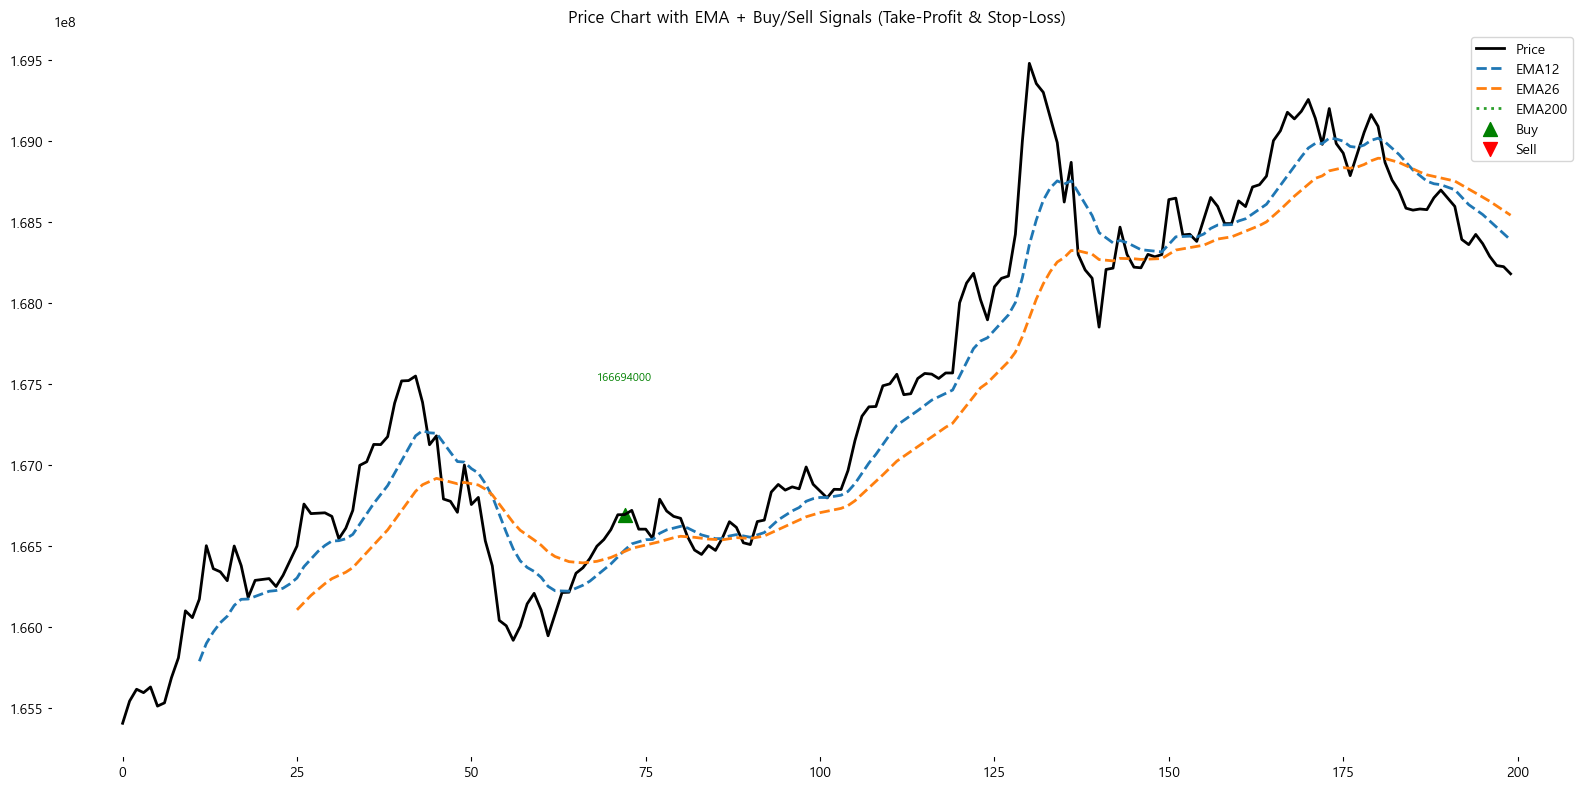

In [50]:
# === 매매 로직 적용 ===
take_profit = 0.05   # 익절 5%
stop_loss = 0.02     # 손절 2%

df['buy_signal'] = False
df['sell_signal'] = False

position = False
entry_price = 0

for i in range(1, len(df)):
    price = df['trade_price'].iloc[i]

    # 매수 조건: EMA12 골든크로스
    if not position and df['ema12'].iloc[i] > df['ema26'].iloc[i] and df['ema12'].iloc[i-1] <= df['ema26'].iloc[i-1]:
        df.loc[df.index[i], 'buy_signal'] = True
        entry_price = price
        position = True

    # 매도 조건: 익절 / 손절
    elif position:
        if price >= entry_price * (1 + take_profit) or price <= entry_price * (1 - stop_loss):
            df.loc[df.index[i], 'sell_signal'] = True
            position = False
            entry_price = 0

# === 시각화 ===
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['trade_price'], label='Price', color='black')
plt.plot(df.index, df['ema12'], label='EMA12', linestyle='--')
plt.plot(df.index, df['ema26'], label='EMA26', linestyle='--')
plt.plot(df.index, df['ema200'], label='EMA200', linestyle=':')

# Buy / Sell 신호 표시 (점 + 텍스트)
buy_points = df[df['buy_signal']]
sell_points = df[df['sell_signal']]

plt.scatter(buy_points.index, buy_points['trade_price'], marker='^', color='green', label='Buy', s=100)
plt.scatter(sell_points.index, sell_points['trade_price'], marker='v', color='red', label='Sell', s=100)

# 텍스트 추가
for idx, row in buy_points.iterrows():
    plt.text(idx, row['trade_price'] * 1.005, f"{row['trade_price']:.0f}", color='green', fontsize=8, ha='center')

for idx, row in sell_points.iterrows():
    plt.text(idx, row['trade_price'] * 0.995, f"{row['trade_price']:.0f}", color='red', fontsize=8, ha='center')

plt.title("Price Chart with EMA + Buy/Sell Signals (Take-Profit & Stop-Loss)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

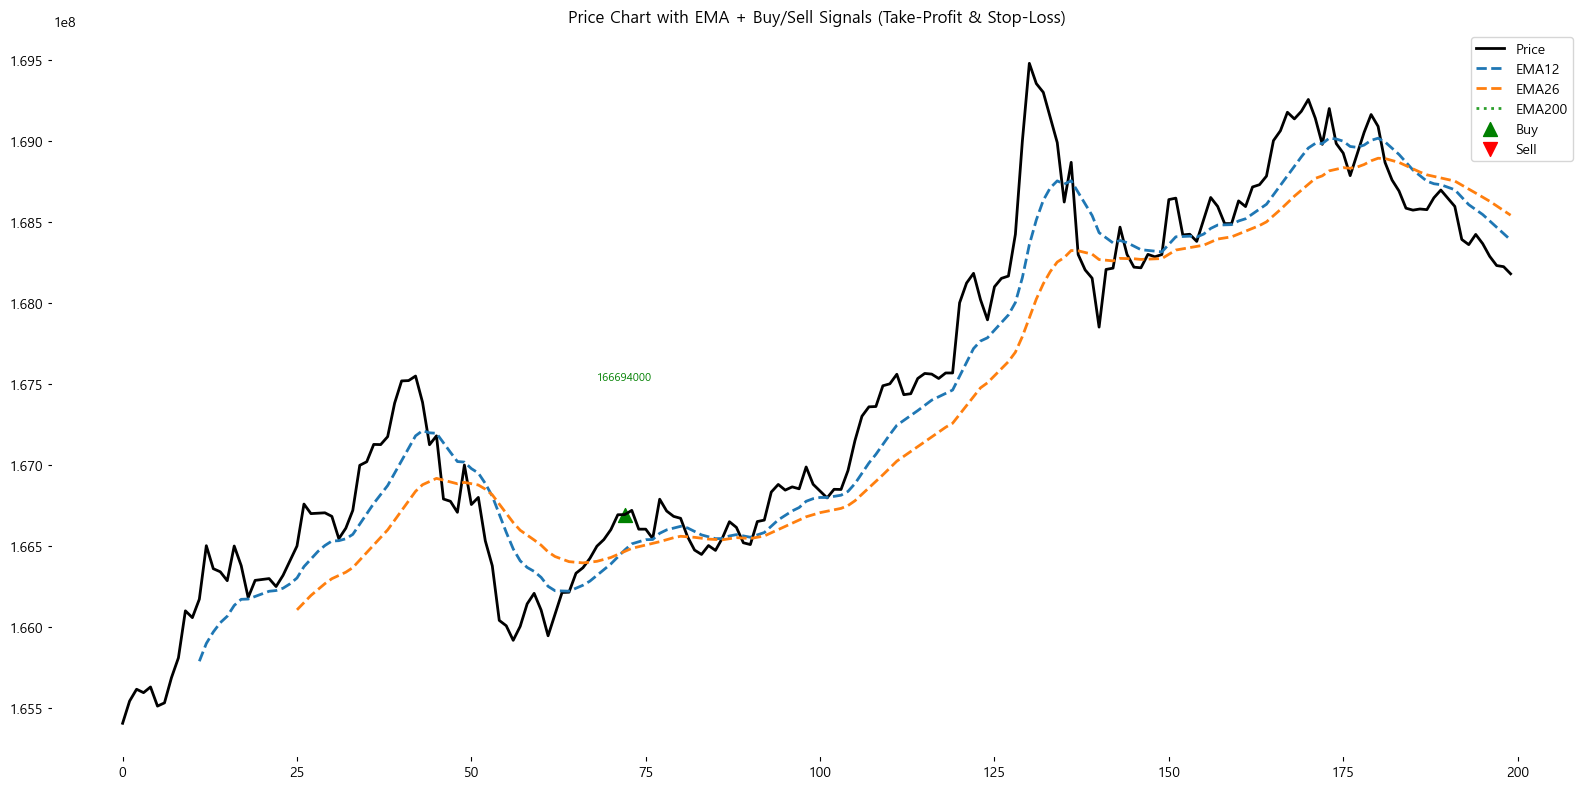

In [51]:
take_profit = 0.12   # 익절 8%
stop_loss = -0.1    # 손절 -5%

df['buy_signal'] = False
df['sell_signal'] = False

position = False
entry_price = 0

for i in range(1, len(df)):
    price = df['trade_price'].iloc[i]

    # 매수 조건: EMA12 골든크로스
    if not position and df['ema12'].iloc[i] > df['ema26'].iloc[i] and df['ema12'].iloc[i-1] <= df['ema26'].iloc[i-1]:
        df.loc[df.index[i], 'buy_signal'] = True
        entry_price = price
        position = True

    # 매도 조건: EMA12 데드크로스 시점에만 체크
    elif position and df['ema12'].iloc[i] < df['ema26'].iloc[i] and df['ema12'].iloc[i-1] >= df['ema26'].iloc[i-1]:
        profit_rate = (price - entry_price) / entry_price

        if profit_rate <= stop_loss:  # -5% 이하 무조건 손절
            df.loc[df.index[i], 'sell_signal'] = True
            position = False
            entry_price = 0

        elif profit_rate >= take_profit:  # +8% 이상 익절
            df.loc[df.index[i], 'sell_signal'] = True
            position = False
            entry_price = 0

        else:
            # 아직 -5%~+8% 구간이면 매도 보류 → 다음 데드크로스까지 보유
            pass


# === 시각화 ===
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['trade_price'], label='Price', color='black')
plt.plot(df.index, df['ema12'], label='EMA12', linestyle='--')
plt.plot(df.index, df['ema26'], label='EMA26', linestyle='--')
plt.plot(df.index, df['ema200'], label='EMA200', linestyle=':')

# Buy / Sell 신호 표시 (점 + 텍스트)
buy_points = df[df['buy_signal']]
sell_points = df[df['sell_signal']]

plt.scatter(buy_points.index, buy_points['trade_price'], marker='^', color='green', label='Buy', s=100)
plt.scatter(sell_points.index, sell_points['trade_price'], marker='v', color='red', label='Sell', s=100)

# 텍스트 추가
for idx, row in buy_points.iterrows():
    plt.text(idx, row['trade_price'] * 1.005, f"{row['trade_price']:.0f}", color='green', fontsize=8, ha='center')

for idx, row in sell_points.iterrows():
    plt.text(idx, row['trade_price'] * 0.995, f"{row['trade_price']:.0f}", color='red', fontsize=8, ha='center')

plt.title("Price Chart with EMA + Buy/Sell Signals (Take-Profit & Stop-Loss)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [52]:
df['buy_signal'] = False
df['sell_signal'] = False

for i in range(1, len(df)):
    # 골든크로스 (EMA12가 EMA26을 위로 돌파)
    if df['ema12'].iloc[i] > df['ema26'].iloc[i] and df['ema12'].iloc[i-1] <= df['ema26'].iloc[i-1]:
        df.loc[df.index[i], 'buy_signal'] = True

    # 데드크로스 (EMA12가 EMA26을 아래로 돌파)
    elif df['ema12'].iloc[i] < df['ema26'].iloc[i] and df['ema12'].iloc[i-1] >= df['ema26'].iloc[i-1]:
        df.loc[df.index[i], 'sell_signal'] = True


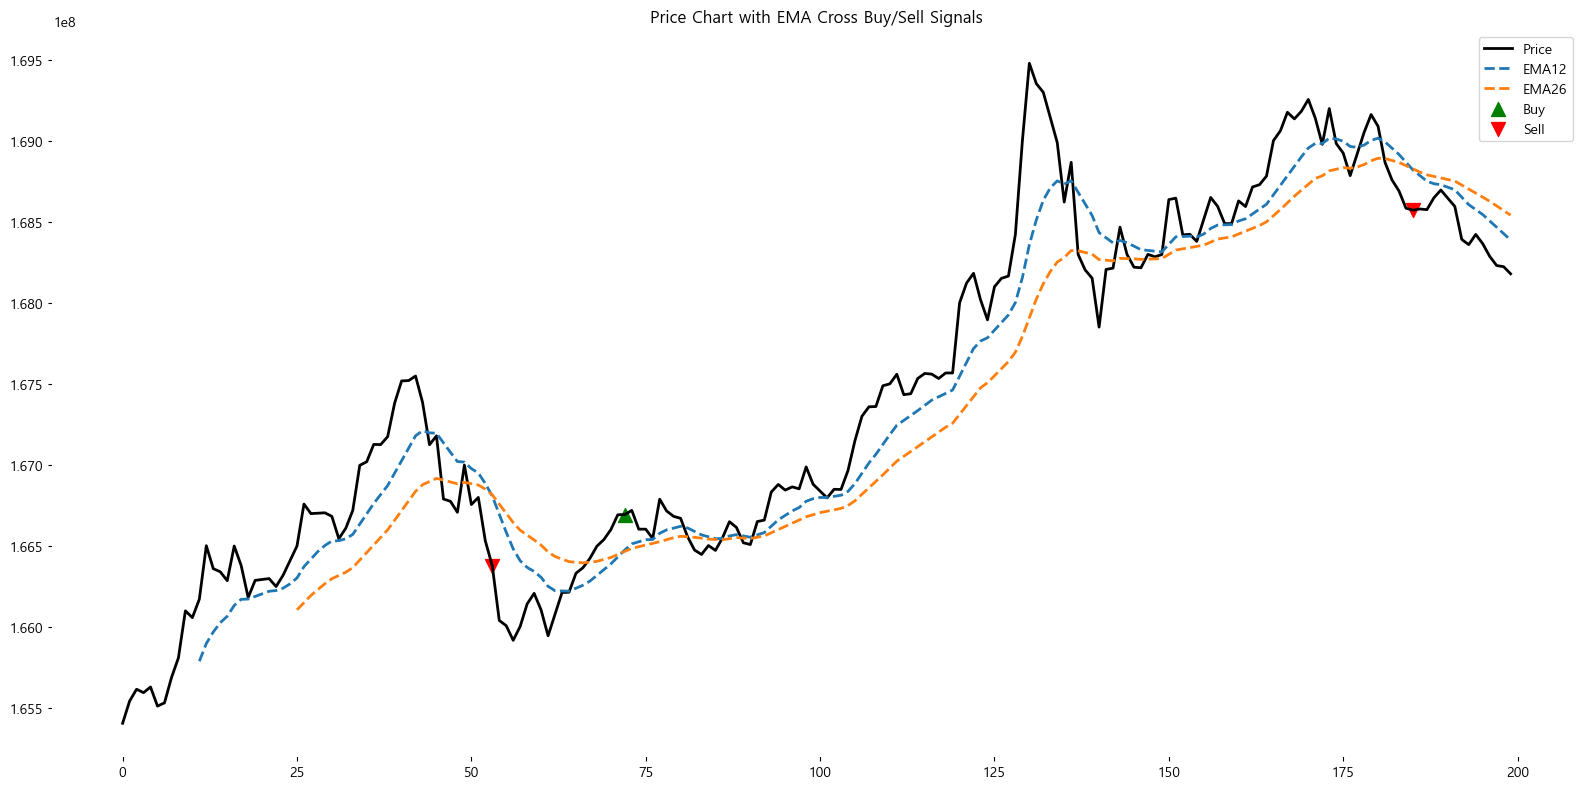

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(df.index, df['trade_price'], label='Price', color='black')
plt.plot(df.index, df['ema12'], label='EMA12', linestyle='--')
plt.plot(df.index, df['ema26'], label='EMA26', linestyle='--')

# 신호 표시
buy_points = df[df['buy_signal']]
sell_points = df[df['sell_signal']]

plt.scatter(buy_points.index, buy_points['trade_price'], marker='^', color='green', label='Buy', s=100)
plt.scatter(sell_points.index, sell_points['trade_price'], marker='v', color='red', label='Sell', s=100)

plt.title("Price Chart with EMA Cross Buy/Sell Signals")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [64]:
take_profit = 0.01   # +8% 익절
stop_loss = -0.01    # -5% 손절

df['buy_signal'] = False
df['sell_signal'] = False
df['profit_rate'] = None   # 매도 시 수익률 기록

position = False
entry_price = 0
entry_index = None

trades = []  # (매수일, 매도가, 수익률) 저장

for i in range(1, len(df)):
    price = df['trade_price'].iloc[i]

    # 매수: 골든크로스
    if not position and df['ema12'].iloc[i] > df['ema26'].iloc[i] and df['ema12'].iloc[i-1] <= df['ema26'].iloc[i-1]:
        df.loc[df.index[i], 'buy_signal'] = True
        entry_price = price
        entry_index = df.index[i]
        position = True

    # 매도: 데드크로스에서만 체크
    elif position and df['ema12'].iloc[i] < df['ema26'].iloc[i] and df['ema12'].iloc[i-1] >= df['ema26'].iloc[i-1]:
        profit_rate = (price - entry_price) / entry_price

        if profit_rate <= stop_loss or profit_rate >= take_profit:
            df.loc[df.index[i], 'sell_signal'] = True
            df.loc[df.index[i], 'profit_rate'] = profit_rate

            trades.append({
                'buy_date': entry_index,
                'sell_date': df.index[i],
                'entry_price': entry_price,
                'exit_price': price,
                'profit_rate': profit_rate
            })

            position = False
            entry_price = 0
            entry_index = None
        else:
            # 조건 안 맞으면 보류 → 다음 데드크로스까지 기다림
            pass

# 결과 요약
print("총 거래 횟수:", len(trades))
if trades:
    avg_profit = sum(t['profit_rate'] for t in trades) / len(trades)
    print("평균 수익률: {:.2%}".format(avg_profit))

    for t in trades:
        print(f"매수일 {t['buy_date']} / 매도가 {t['exit_price']:.0f} / 수익률 {t['profit_rate']:.2%}")


총 거래 횟수: 1
평균 수익률: 1.13%
매수일 72 / 매도가 168573000 / 수익률 1.13%


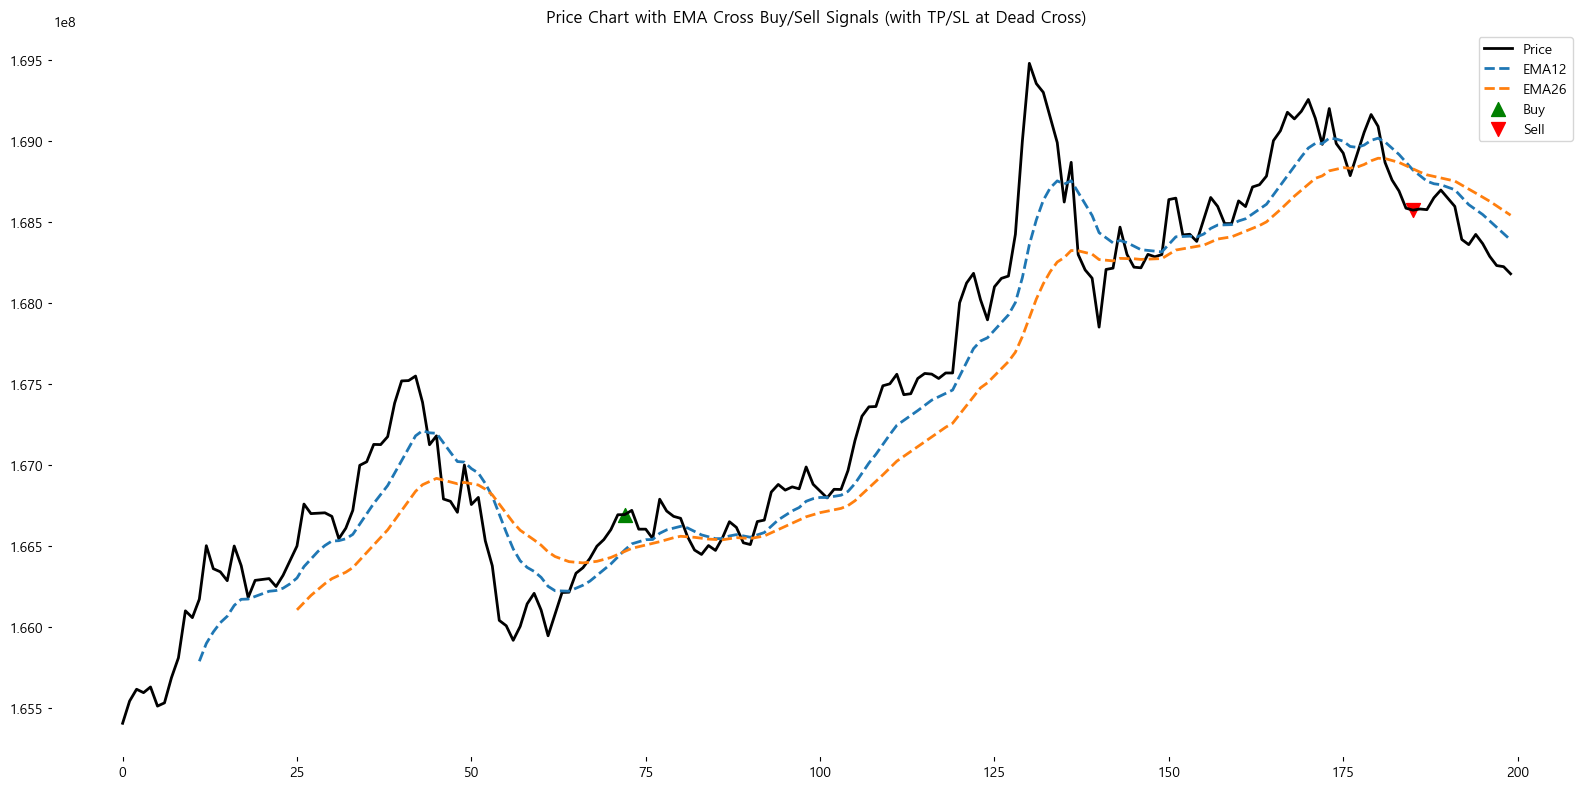

In [65]:
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['trade_price'], label='Price', color='black')
plt.plot(df.index, df['ema12'], label='EMA12', linestyle='--')
plt.plot(df.index, df['ema26'], label='EMA26', linestyle='--')

buy_points = df[df['buy_signal']]
sell_points = df[df['sell_signal']]

plt.scatter(buy_points.index, buy_points['trade_price'], marker='^', color='green', label='Buy', s=100)
plt.scatter(sell_points.index, sell_points['trade_price'], marker='v', color='red', label='Sell', s=100)

plt.title("Price Chart with EMA Cross Buy/Sell Signals (with TP/SL at Dead Cross)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
